# Multidimensional Integral Estimation using Gibbs Sampling with Accept-Reject
This notebook demonstrates how to estimate a multidimensional integral using Gibbs sampling with an accept-reject step. Each variable is updated in turn while the others are held constant.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import Generator, MT19937
import time

# Initialize random number generator
seed = int(time.time())
rng = Generator(MT19937(seed))

In [2]:
# User-defined target PDF (multivariate standard normal by default)
def target_pdf(x):
    x = np.asarray(x)
    return np.exp(-0.5 * np.sum(x**2, axis=-1)) / (2 * np.pi) ** (x.shape[-1]/2)

def f(x):
    x = np.asarray(x)
    return np.exp(-np.sum(x**2, axis=-1))

In [3]:
# Gibbs sampler with accept-reject step for D dimensions
def gibbs_accept_reject(x0, thinning, burnin, N, step_size, target_pdf):
    d = len(x0)
    samples = []
    x = np.array(x0)
    for _ in range(N):
        for j in range(d):
            x_prop = x.copy()
            x_prop[j] = x[j] + rng.uniform(-step_size, step_size)
            # Accept-reject step for this variable
            acc_ratio = target_pdf(x_prop) / target_pdf(x)
            if rng.uniform() < acc_ratio:
                x[j] = x_prop[j]
        samples.append(x.copy())
    # Apply thinning and burn-in
    samples = samples[::thinning]
    samples = samples[burnin:]
    return np.array(samples)

In [4]:
# Importance sampling integration for multidimensional case
def importance_integration(f, target_pdf, m_chain):
    weights = f(m_chain) / target_pdf(m_chain)
    estimate = np.mean(weights)
    return estimate

In [5]:
# Example usage: choose dimension d
D = 3  # Change this for different dimensions
N = 100_000
x0 = np.zeros(D)
thinning = 1
burnin = int(0.1 * N)
step_size = 2.0

m_chain = gibbs_accept_reject(x0, thinning, burnin , N, step_size, target_pdf)
Integral = importance_integration(f, target_pdf, m_chain)
print(f"Estimated integral in {D}D using Gibbs sampling: {Integral}")
print("Actual value is ", np.pi ** (D/2))

Estimated integral in 3D using Gibbs sampling: 5.5754964909734595
Actual value is  5.568327996831708


In [6]:
# Vary the step size, compute the integral multiple times for each, and show deviation from the true value
D = 5
N = 100_000
x0 = np.zeros(D)
thinning = 1
burnin = int(N * 0.1)
actual_value = np.pi ** (D/2)

step_sizes = np.linspace(0.5, 5.0, 10)
repeats = 10  # Number of runs per step size
means = []
stds = []

for step_size in step_sizes:
    estimates = []
    for _ in range(repeats):
        m_chain = gibbs_accept_reject(x0, thinning, burnin, N, step_size, target_pdf)
        estimate = importance_integration(f, target_pdf, m_chain)
        estimates.append(estimate)
    means.append(np.mean(estimates))
    stds.append(np.std(estimates))

plt.figure(figsize=(8, 5))
plt.errorbar(step_sizes, means, yerr=stds, fmt='o-', capsize=5, label='Estimated Integral')
plt.axhline(y=actual_value, color='red', linestyle='--', label=f'True Value (pi^{{3/2}} ≈ {actual_value:.3f})')
plt.xlabel('Step Size')
plt.ylabel('Integral Estimate')
plt.title('Integral Estimate vs Step Size (with Std Dev)')
plt.legend()
plt.grid(True)
plt.show()

KeyboardInterrupt: 

You can change the value of `D` in the example usage cell to try different numbers of dimensions. The code will estimate the integral of exp(-sum(x**2)) over R^D using Gibbs sampling with accept-reject and importance sampling.

# Conway binning analysis for Gibbs Sampling

In [7]:
#Blocking Variance

def blocking_variance(series, min_blocks=4):
    """
    Return
        bin_sizes  – powers-of-2 block lengths
        var_mean   – variance of the MCMC mean at each block size
        err_var    – 1-σ uncertainty of that variance
    """
    N = len(series)
    max_power = int(np.log2(N // min_blocks))
    bin_sizes = 2 ** np.arange(max_power + 1)

    var_mean, err_var = [], []
    for L in bin_sizes:
        n_blocks = N // L
        if n_blocks < min_blocks:               # need ≥ min_blocks estimates
            break
        # reshape   → one mean per block
        blocks = series[:n_blocks * L].reshape(n_blocks, L).mean(axis=1)

        s2      = blocks.var(ddof=1)            # unbiased σ² of block means
        v_mean  = s2 / n_blocks                 # Var[overall mean]
        var_mean.append(v_mean)

        # 1-σ error bar from χ² statistics
        err_var.append(v_mean * np.sqrt(2 / (n_blocks - 1)))

    return bin_sizes[:len(var_mean)], np.array(var_mean), np.array(err_var)

In [8]:
# ------------------------------------------------------------
# tiny plateau finder
# ------------------------------------------------------------

def plateau_variance(bin_sizes, variances, window=3, tolerance=0.04):
    """
    Mean of first 'window' consecutive points whose relative stdev < tolerance.
    Returns (variance_est, index_of_rightmost_point).
    """
    if len(variances) < window:
        return variances[-1], len(variances) - 1

    for i in range(len(variances) - window + 1):
        w = variances[i:i + window]
        if np.std(w) / np.mean(w) < tolerance:
            return np.mean(w), i + window - 1
    # fallback: last point
    return variances[-1], len(variances) - 1

======  blocking-plateau variance estimate  ======
Var[mean] ≈ 1.8187e-05  ± 2.4e-07
Std error ≈ 4.2646e-03
======  blocking-plateau variance estimate  ======
Var[mean] ≈ 9.3027e-05  ± 1.7e-06
Std error ≈ 9.6450e-03
======  blocking-plateau variance estimate  ======
Var[mean] ≈ 3.9581e-04  ± 5.2e-06
Std error ≈ 1.9895e-02
======  blocking-plateau variance estimate  ======
Var[mean] ≈ 1.6152e-03  ± 2.1e-05
Std error ≈ 4.0189e-02
======  blocking-plateau variance estimate  ======
Var[mean] ≈ 6.4196e-03  ± 8.4e-05
Std error ≈ 8.0123e-02
======  blocking-plateau variance estimate  ======
Var[mean] ≈ 2.5159e-02  ± 3.3e-04
Std error ≈ 1.5862e-01
======  blocking-plateau variance estimate  ======
Var[mean] ≈ 9.8440e-02  ± 1.8e-03
Std error ≈ 3.1375e-01
======  blocking-plateau variance estimate  ======
Var[mean] ≈ 3.5899e-01  ± 4.7e-03
Std error ≈ 5.9916e-01
======  blocking-plateau variance estimate  ======
Var[mean] ≈ 1.3299e+00  ± 1.7e-02
Std error ≈ 1.1532e+00


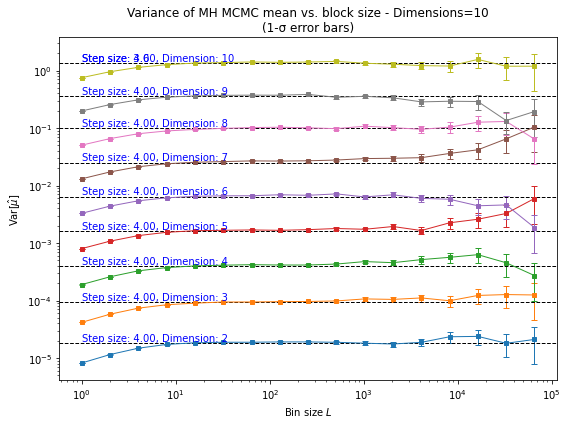

In [9]:
# --- 0. parameters ----------------------------------------
plateau_points = []
plt.figure(figsize=(8, 6))
step_size = 3.0  # Step size for the proposal distribution
N = 1_000_000  # Total number of samples to generate
for D in [2, 3, 4, 5, 6, 7, 8, 9, 10]:  # Dimensions to test
    step_size = 4  # Step size for the proposal distribution
    x0 = rng.uniform(-step_size, step_size, size=D) # Initial point for the Markov chain rng.uniform(-step_size, step_size)

    burnin = int(0.1 * N)  # Number of samples to discard as burn-in
    thinning = 2  # Thinning factor for the Markov chain

    # --- 1. generate a correlated chain (AR(1)) -----------------
    markov_chain = gibbs_accept_reject(x0, thinning, burnin, N, step_size, target_pdf)#metropolis_hastings(x0, thinning, burnin, N, step_size, target_pdf)

    f_i = f(markov_chain)/ target_pdf(markov_chain)  # Importance weights for the samples

    # --- 2. blocking analysis with error bars ------------------
    bin_sizes, vars_mean, errs = blocking_variance(f_i)

    # automatic plateau estimate
    v_hat, idx = plateau_variance(bin_sizes, vars_mean)
    err_hat    = errs[idx]

    print("======  blocking-plateau variance estimate  ======")
    print(f"Var[mean] ≈ {v_hat:.4e}  ± {err_hat:.1e}")
    print(f"Std error ≈ {np.sqrt(v_hat):.4e}")

    # 2. plot ----------------------------------------------------
    plt.errorbar(bin_sizes, vars_mean, yerr=errs,
            fmt='-s', capsize=3, linewidth=1, markersize=4)

    # <<< NEW: horizontal line through the plateau value >>>
    plt.axhline(v_hat, color='k', linestyle='--', linewidth=1,
            label=f'plateau variance ≈ {v_hat:.2e}')
    plt.text(bin_sizes[0], v_hat, f"Step size: {step_size:.2f}, Dimension: {D}", fontsize=10, color='blue', verticalalignment='bottom')

    plateau_points.append(bin_sizes[idx])
    step_size *= 0.9  # Increase step size for the next dimension
plateau_points = np.array(plateau_points)

plt.xscale('log'); plt.yscale('log')
plt.xlabel("Bin size $L$")
plt.ylabel(r"Var[$\hat\mu$]")
plt.title(f"Variance of Gibbs MCMC mean vs. block size - Dimensions={D}\n(1-σ error bars)")
plt.tight_layout()
plt.text(bin_sizes[0], v_hat, f"Step size: {step_size}", fontsize=10, color='blue', verticalalignment='bottom')
#plt.savefig(f"plots/Many_Step_Mult_Dim_Variance_of_MCMC_mean_vs_block_size_step={step_size}_dimension_{D}.pdf", format="pdf")
plt.show()
plt.close()

